<a href="https://colab.research.google.com/github/RyanChen12035/w266_final_Anatomy-and-Structured-Prunning/blob/main/anatomy_gradient_analysis_llama2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U accelerate peft trl bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 45.8 MB/s eta 0:00:00


In [1]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer

In [2]:
# base model for standard 7b model and new model for QLORA version
base_model = "NousResearch/Llama-2-7b-chat-hf"
#Load the tokenizer from Llama 2
tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True)
#Use End of Sentence token for fine-tuning
tokenizer.pad_token=tokenizer.eos_token
tokenizer.padding_side="right"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
# define the quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    #Quant type
    #introduced in the QLoRA paper
    bnb_4bit_quant_type="nf4",
    #As the model weights are stored using 4 bits and when we want to compute its only going to use 16 bits so we have more accuracy
    bnb_4bit_compute_dtype=torch.float16,
    #Quantization parameters are quantized
    bnb_4bit_use_double_quant=True
)

# Load the quantized verion of model to reduce the memory cost and configure it to return hidden states
model = AutoModelForCausalLM.from_pretrained(base_model,
    output_hidden_states=True,
    quantization_config=bnb_config,
    device_map={"": 0}   # to GPU
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

In [4]:
import tensorflow_datasets as tfds
train_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

train_examples, train_labels = next(iter(train_data.batch(100)))

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
model.train()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


In [11]:
# Process the texts to create inputs
texts = [text.decode('utf-8') for text in train_examples[:8].numpy()]
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
inputs = inputs.to(device)


# Forward pass to get outputs; ensure output_hidden_states is True to get all hidden states
outputs = model(**inputs)
hidden_states = outputs.hidden_states
last_logits = hidden_states[-1][:, -1 ,:]  # This contains the logits from the last layer
# all_hidden_states = outputs.hidden_states  # This contains the outputs from each layer

# Function to apply hooks
gradients = {}
def save_grad(layer):
    def hook(module, grad_input, grad_output):
        # Here we store the mean of the gradients for each token across the batch
        gradients[layer] = grad_output[0].mean(dim=0).clone().detach().cpu().numpy()
        return None
    return hook

# Apply hooks to all transformer layers
for i, layer in enumerate(model.model.layers):
    layer.register_full_backward_hook(save_grad(f'Layer {i+1}'))

# Compute gradients
# Assuming you want to use logits, select the last logits, as previously described
output = last_logits.mean(dim=0).sum()  # Scalar to compute gradients
output.backward()

# Printing gradients to check
for key, value in gradients.items():
    print(f"Gradients for {key}: {value.shape}")

Gradients for Layer 32: (128, 4096)
Gradients for Layer 31: (128, 4096)
Gradients for Layer 30: (128, 4096)
Gradients for Layer 29: (128, 4096)
Gradients for Layer 28: (128, 4096)
Gradients for Layer 27: (128, 4096)
Gradients for Layer 26: (128, 4096)
Gradients for Layer 25: (128, 4096)
Gradients for Layer 24: (128, 4096)
Gradients for Layer 23: (128, 4096)
Gradients for Layer 22: (128, 4096)
Gradients for Layer 21: (128, 4096)
Gradients for Layer 20: (128, 4096)
Gradients for Layer 19: (128, 4096)
Gradients for Layer 18: (128, 4096)
Gradients for Layer 17: (128, 4096)
Gradients for Layer 16: (128, 4096)
Gradients for Layer 15: (128, 4096)
Gradients for Layer 14: (128, 4096)
Gradients for Layer 13: (128, 4096)
Gradients for Layer 12: (128, 4096)
Gradients for Layer 11: (128, 4096)
Gradients for Layer 10: (128, 4096)
Gradients for Layer 9: (128, 4096)
Gradients for Layer 8: (128, 4096)
Gradients for Layer 7: (128, 4096)
Gradients for Layer 6: (128, 4096)
Gradients for Layer 5: (128, 409

In [12]:
print(len(hidden_states))
print(last_logits.shape)
print(output)

33
torch.Size([8, 4096])
tensor(33.5000, device='cuda:0', dtype=torch.float16, grad_fn=<SumBackward0>)


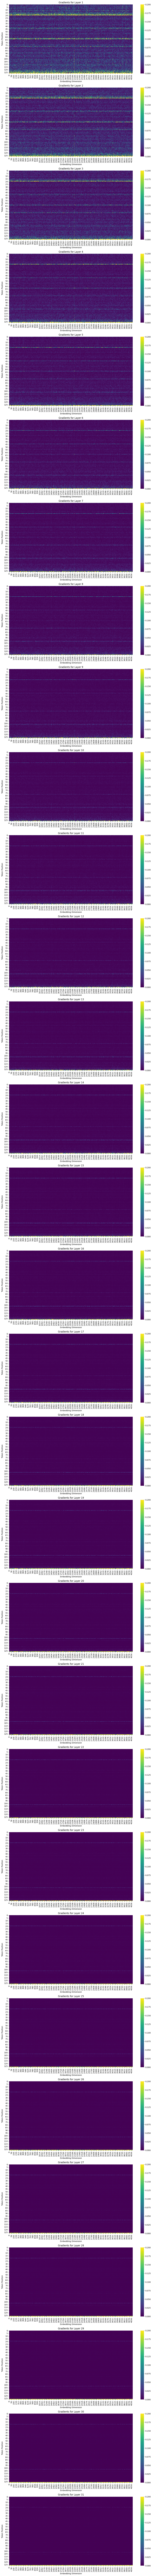

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# layers_to_visualize = ['Layer 1','Layer 15','Layer 22','Layer 29']
layers_to_visualize = ['Layer {}'.format(i) for i in range(1, 32)]

# Setup the number of subplots needed based on the layers you want to visualize
num_layers = len(layers_to_visualize)
fig, axes = plt.subplots(num_layers, 1, figsize=(12, 6 * num_layers))  # Adjust size as needed

# Define the colorbar range
vmin = 0  # Minimum value of the gradient magnitude to display
vmax = 0.2  # Maximum value of the gradient magnitude to display

# Loop through each layer and create a heatmap
for ax, layer in zip(axes, layers_to_visualize):
    gradient_matrix = gradients[layer]

    first_20_tokens = gradient_matrix[1:, :] # exclude cls
    # Plot heatmap
    sns.heatmap(abs(first_20_tokens), ax=ax, cmap='viridis', cbar=True, vmin=vmin, vmax=vmax)
    ax.set_title(f'Gradients for {layer}')
    ax.set_xlabel('Embedding Dimension')
    ax.set_ylabel('Token Position')

    # ax.set_yticks(np.arange(20))  # Set y-ticks to show each token position
    # ax.set_yticklabels(np.arange(1, 21))  # Label from 1 to 20 for clarity

# Show the plot
plt.tight_layout()
plt.show()

# plot only first 20 token postions

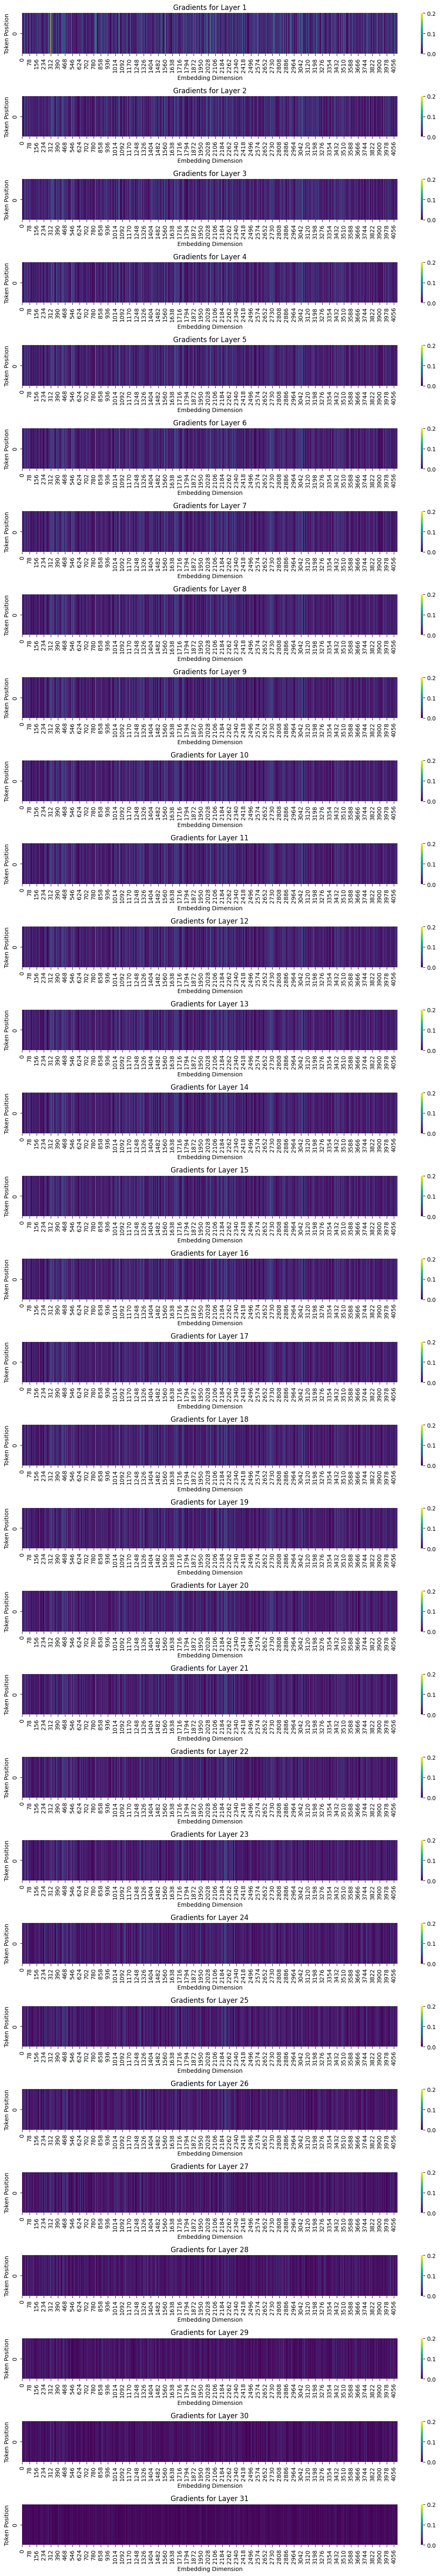

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

layers_to_visualize = ['Layer {}'.format(i) for i in range(1, 32)]

# Setup the number of subplots needed based on the layers you want to visualize
num_layers = len(layers_to_visualize)
fig, axes = plt.subplots(num_layers, 1, figsize=(12, 2 * num_layers))  # Adjust size as needed

# Define the colorbar range
vmin = 0  # Minimum value of the gradient magnitude to display
vmax = 0.2 # Maximum value of the gradient magnitude to display


# Loop through each layer and create a heatmap
for ax, layer in zip(axes, layers_to_visualize):
    gradient_matrix = gradients[layer]

    first_20_tokens = gradient_matrix[0:1, :] # only cls
    # Plot heatmap
    sns.heatmap(abs(first_20_tokens), ax=ax, cmap='viridis', cbar=True, vmin=vmin, vmax=vmax)
    ax.set_title(f'Gradients for {layer}')
    ax.set_xlabel('Embedding Dimension')
    ax.set_ylabel('Token Position')

# Show the plot
plt.tight_layout()
plt.show()

# plot only first 20 token postions

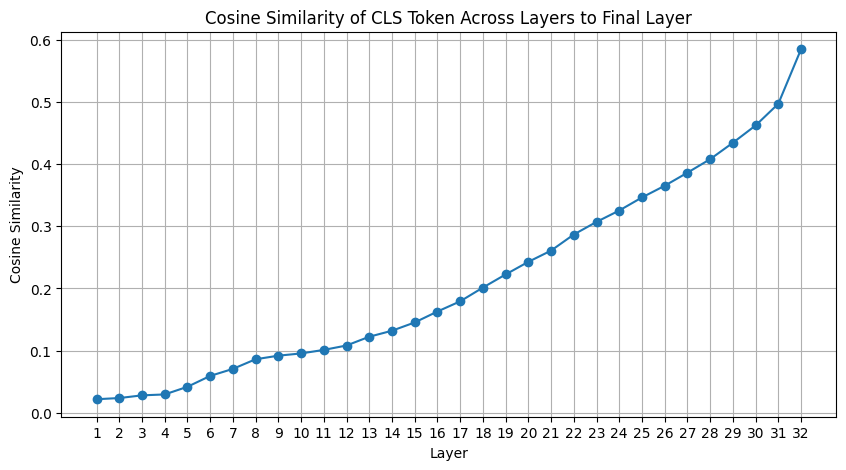

In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming hidden_states is obtained from the model outputs
logit_similarities = []
final_logit = hidden_states[-1][:, -1, :]

for i in range(len(hidden_states) - 1):  # Exclude the last layer as it is used for comparison
    current_logit = hidden_states[i][:, -1, :]  # First token of each layer
    # Compute cosine similarity and take the mean across the batch if needed
    cosine_sim = F.cosine_similarity(current_logit, final_logit, dim=1).mean().item()
    logit_similarities.append(cosine_sim)

# Plot the cosine similarities between the CLS token of each layer and the last layer's CLS token
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(hidden_states)), logit_similarities, marker='o', linestyle='-')
plt.title('Cosine Similarity of CLS Token Across Layers to Final Layer')
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')
plt.xticks(range(1, len(hidden_states)))  # Adjust the x-ticks to match layer numbers
plt.grid(True)
plt.show()
